#  Using LangChain and OpenAI API to assist exploratory data analysis

## Before we begin

You'll need a developer account with OpenAI.

refer the article for steps on how to create an API key and store it in environment.

## Task 0: Setup

We need to install the `langchain` package.

The `langchain` depends on a recent version of `typing_extensions`, so we need to update that package.

### Instructions

Run the following code to install `langchain` and `typing_extensions`.

In [ ]:
# Install the langchain package
!pip install langchain==0.0.300

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.3/384.3 kB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 9.1 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gremlinpython 3.6.1 requires aiohttp<=3.8.1,>=3.8.0, but you have aiohttp 3.9.1 which is incompatible.


In [ ]:
# Update the typing_extensions package
!pip install typing_extensions==4.8.0

Defaulting to user installation because normal site-packages is not writeable


To chat with GPT, we first need to load the `openai` and `os` packages to set the API key from the environment variables you just created.

In [ ]:
# Import the os package
import os

# Import the openai package
import openai

# Set openai.api_key to the OPENAI_API_KEY environment variable
openai.api_key = os.environ['OPENAI_KEY']

We need to import the `langchain` package. It has many submodules, so to save typing later, we'll also import some specific functions from those submodules.

In [ ]:
# Import the langchain package as lc
import langchain as lc

# From the langchain.chat_models module, import ChatOpenAI
from langchain.chat_models import ChatOpenAI

# From the langchain.schema module, import AIMessage, HumanMessage, SystemMessage
from langchain.schema import AIMessage, HumanMessage, SystemMessage

You'll also need to do some light data manipulation with the `pandas` package and data visualization with `plotly.express`.  Finally, the `IPython.display` pacakges contains functions to prettily display Markdown content.

In [ ]:
# Import pandas using the alias pd
import pandas as pd

# Import plotly.express using the alias px
import plotly.express as px

# From the IPython.display package, import display and Markdown
from IPython.display import display, Markdown

## Task 1: Import the Electric Cars Data

The electric cars data has been pre-processed and is contained in a CSV file named `electric_cars.csv`.

Each row in the dataset represents the count of the number of cars registered within a city, for a particular model.

The dataset contains the following columns.

- `city` (character): The city in which the registered owner resides.
- `county` (character): The county in which the registered owner resides.
- `model_year` (integer): The [model year](https://en.wikipedia.org/wiki/Model_year#United_States_and_Canada) of the car.
- `make` (character): The manufacturer of the car.
- `model` (character): The model of the car.
- `electric_vehicle_type` (character): Either "Plug-in Hybrid Electric Vehicle (PHEV)" or "Battery Electric Vehicle (BEV)".
- `n_cars` (integer): The count of the number of vehicles registered.

Our first step is to import and print the data.

In [ ]:
# Read the data from electric_cars.csv. Assign to electric_cars.
electric_cars = pd.read_csv('electric_cars.csv')

# Display a description of the numeric columns
print("Description of numeric columns\n")
display(electric_cars.describe())

# Display a description of the text (object) columns
print("Description of text columns\n")
display(electric_cars.describe(include="O"))

# Print the whole dataset
print("The electric cars dataset\n")
display(electric_cars)

Description of numeric columns



,model_year,n_cars
count,26813.000000,26813.000000
mean,2019.375527,5.612166
std,3.286257,26.997325
min,1997.000000,1.000000
25%,2017.000000,1.000000
50%,2020.000000,2.000000
75%,2022.000000,4.000000
max,2024.000000,1514.000000


Description of text columns



,city,county,make,model,electric_vehicle_type
count,26813,26813,26813,26813,26813
unique,683,183,37,127,2
top,Bothell,King,TESLA,LEAF,Battery Electric Vehicle (BEV)
freq,479,7066,5071,1889,15885


The electric cars dataset



,city,county,model_year,make,model,electric_vehicle_type,n_cars
0,Seattle,King,2023,TESLA,MODEL Y,Battery Electric Vehicle (BEV),1514
1,Seattle,King,2018,TESLA,MODEL 3,Battery Electric Vehicle (BEV),1153
2,Seattle,King,2021,TESLA,MODEL Y,Battery Electric Vehicle (BEV),1147
3,Seattle,King,2022,TESLA,MODEL Y,Battery Electric Vehicle (BEV),1122
4,Bellevue,King,2023,TESLA,MODEL Y,Battery Electric Vehicle (BEV),931
...,...,...,...,...,...,...,...
26808,Lakewood,Pierce,2022,BMW,IX,Battery Electric Vehicle (BEV),1
26809,Lakewood,Pierce,2022,BMW,X5,Plug-in Hybrid Electric Vehicle (PHEV),1
26810,Lakewood,Pierce,2022,FORD,TRANSIT,Battery Electric Vehicle (BEV),1
26811,Lakewood,Pierce,2022,HYUNDAI,KONA ELECTRIC,Battery Electric Vehicle (BEV),1


## Task 2: Asking GPT a Question

Let's initiate the connection by sending a message to GPT and getting a response. For now, we won't worry about including any details about the dataset.

We'll also skip using langchain for now so you can see more clearly how the `openai` packages works.

### Types of Message

There are three types of message, documented in the [Introduction](https://platform.openai.com/docs/guides/chat/introduction) to the Chat documentation. We'll use two of them here.

- `system` messages describe the behavior of the AI assistant. It could be used to set the context and tone for the Assisstant.
If you don't know what you want, try "You are a helpful assistant".
- `user` messages describe what you want the AI assistant to say. We'll cover examples of this today.

### Instructions

Send a question to GPT and get a response.

- Define the system message as follows and assign to `system_msg_test`.

```
"""You are a helpful assistant who has a good understanding of data science. Your way of writing is very clear and simple. You keep your answers brief.""".
```
    
- Define the user message as follows and assign to `user_msg_test`.

```
"Tell me some uses of GPT for data analysis."
```

- Create a message list from the system and user messages. Assign to `msgs_test`.
- Send the messages to GPT. Assign to `rsps_test`.

In [ ]:
# Define the system message. Assign to system_msg_test.
system_msg_test = "You are a helpful assistant who has a good understanding of data science. Your way of writing is very clear and simple. You keep your answers brief."

# Define the user message. Assign to user_msg_test.
user_msg_test = "Tell me some uses of GPT for data analysis."

# Create a message list from the system and user messages. Assign to msgs_test.
msgs_test = [{"role": "system", "content":system_msg_test},
             {"role": "user", "content":user_msg_test}]

# Send the messages to GPT. Assign to rsps_test.
rsps_test = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=msgs_test
)
# print(rsps_test.choices[0].message.content)

In [ ]:
rsps_test

<OpenAIObject chat.completion id=chatcmpl-8igis8VqYX9ydhcIfCnpJIHBWPE0J at 0x7fbb3d0d2f40> JSON: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "GPT (which stands for Generative Pre-trained Transformer) can be helpful for data analysis in a few different ways. Firstly, it can help with data cleaning and pre-processing, which means making sure the data is in a good condition for analysis. GPT can also be used for data visualization, which means creating pictures or graphs to help understand the data better. Lastly, GPT can be used for data prediction, which means making guesses about what might happen based on the data that has already been collected. Overall, GPT is quite useful for analyzing and understanding data.",
        "role": "assistant"
      }
    }
  ],
  "created": 1705661350,
  "id": "chatcmpl-8igis8VqYX9ydhcIfCnpJIHBWPE0J",
  "model": "gpt-3.5-turbo-0613",
  "object": "chat.completion",

The result is a highly nested Python dictionary like object. The response also includes some metadata based on each request. You'll print the whole thing so you can see the structure, and extract just the text content.

In [ ]:
# Print the whole response
print("The whole response\n")
print(rsps_test)

print("\n\n----\n\n")

# Print just the response's content
print("Just the response's content\n")
print(rsps_test['choices'][0]['message']['content'])

The whole response

{
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "GPT (which stands for Generative Pre-trained Transformer) can be helpful for data analysis in a few different ways. Firstly, it can help with data cleaning and pre-processing, which means making sure the data is in a good condition for analysis. GPT can also be used for data visualization, which means creating pictures or graphs to help understand the data better. Lastly, GPT can be used for data prediction, which means making guesses about what might happen based on the data that has already been collected. Overall, GPT is quite useful for analyzing and understanding data.",
        "role": "assistant"
      }
    }
  ],
  "created": 1705661350,
  "id": "chatcmpl-8igis8VqYX9ydhcIfCnpJIHBWPE0J",
  "model": "gpt-3.5-turbo-0613",
  "object": "chat.completion",
  "system_fingerprint": null,
  "usage": {
    "completion_tokens": 115,
   

## Task 3: Asking a Question About the Dataset

Now we have established that GPT is working, we can start to throw some tasks (ask questions) about data analysis. Because we have details of our dataset, we can pass these in to our prompt to improve the quality of the mesages we get back.

Another change that we're going to make is to use the `langchain` package, which provides a convenience layer on top of the `openai` package.

### Why should we use LangChain?

The code in the previous task used convoluted and nested objects in several occasions (the list of dictionaries for the message, and the dictionary of lists and dictionaries for the response). This sort of object is common in web application development, but not in data analysis, where rectangular data (pandas DataFrames and SQL tables) is more commonplace.

One of the key advantages of LangChain package is that it simplifies the code for some tasks, letting you simplify the response extraction process.

Secondly, if we want to experiment with GPT models, (as one might do in a corporate setting), it can be easier to do so if you use the `langchain` package rather than the `openai` package directly.

### LangChain message types

The LangChain message types are names slightly differently from the OpenAI message types.

- `SystemMessage` is the equivalent of OpenAI's `system` message.
- `HumanMessage` is the equivalent of OpenAI's `user` message.

In [ ]:
# A description of the dataset
dataset_description = """
You have a dataset about electric cars registered in Washington state, USA in 2020. It is available as a pandas DataFrame named `electric_cars`.

Each row in the dataset represents the count of the number of cars registered within a city, for a particular model.

The dataset contains the following columns.

- `city` (character): The city in which the registered owner resides.
- `county` (character): The county in which the registered owner resides.
- `model_year` (integer): The [model year](https://en.wikipedia.org/wiki/Model_year#United_States_and_Canada) of the car.
- `make` (character): The manufacturer of the car.
- `model` (character): The model of the car.
- `electric_vehicle_type` (character): Either "Plug-in Hybrid Electric Vehicle (PHEV)" or "Battery Electric Vehicle (BEV)".
- `n_cars` (integer): The count of the number of vehicles registered.
"""

# Create a task for the AI. Assign to suggest_questions.
suggest_questions = "Suggest some questions about this dataset for performing data analysis and creating insights."

# Concatenate the dataset description and the request. Assign to msgs_suggest_questions.
msgs_suggest_questions = [
    SystemMessage(content="You are a data analysis expert."),
    HumanMessage(content=f"{dataset_description}\n\n{suggest_questions}")
]

In [ ]:
# Create a ChatOpenAI object. Assign to chat.
chat = ChatOpenAI(openai_api_key=os.environ['OPENAI_KEY'])

# Pass your message to GPT. Assign to rsps_suggest_questions.
rsps_suggest_questions = chat(msgs_suggest_questions)

# Print the response
print("The whole response\n")
print(rsps_suggest_questions)

print("\n----\n")

# Print just the response's content
print("Just the response's content\n")
print(rsps_suggest_questions.content)

print("\n----\n")

# Print the type of the response
print("The type of the response\n")
print(type(rsps_suggest_questions))

The whole response

content='1. What is the total number of electric cars registered in Washington state in 2020?\n2. Which city had the highest number of electric cars registered in 2020?\n3. What was the most popular electric car model in Washington state in 2020?\n4. Which county had the highest number of battery electric vehicles (BEVs) registered in 2020?\n5. How many plug-in hybrid electric vehicles (PHEVs) were registered in each county in 2020?\n6. How does the distribution of electric car models differ between different cities in Washington state?\n7. What is the average number of electric cars registered per city in 2020?\n8. Is there a correlation between the model year of the car and the number of registered cars for each model?\n9. How does the distribution of electric vehicle types (BEVs vs PHEVs) vary across different counties in Washington state?\n10. Are there any outliers in the number of registered electric cars for specific models?' additional_kwargs={} example=Fals

## Task 4: Build a longer conversation with GPT

Notice that the response from GPT was a dictionary-like object. The useful and practical part of the response is the `.content` element, which contains the text response to your prompt.

While a single prompt and response can be useful, often you want to have a longer conversation with GPT. In this case, you can pass previous messages so that GPT can "remember" what was said before.

### AI messages

The response from GPT had type `AIMessage`. By distinguishing `AIMessage`s from the `HumanMessage`s, you can tell who said what in a conversation with the AI.

In [ ]:
# Append the response and a new message to the previous messages.
# Assign to msgs_python_top_models.
msgs_python_code = msgs_suggest_questions + [
    rsps_suggest_questions,
    HumanMessage(content="Write a code to find out if there is a correlation between the model year and the count of electric cars registered in Washington state in 2020")
]

# Pass your message to GPT. Assign to rsps_python_top_models.
rsps_python_code = chat(msgs_python_code)

# Display the response's Markdown content
display(Markdown(rsps_python_code.content))

To find out if there is a correlation between the model year and the count of electric cars registered in Washington state in 2020, you can use the `corr()` function in pandas.

Here's the code to calculate the correlation coefficient:

```python
import pandas as pd

# Assuming the dataset is already loaded into the 'electric_cars' DataFrame

# Convert the 'model_year' column to numeric data type
electric_cars['model_year'] = pd.to_numeric(electric_cars['model_year'])

# Calculate the correlation coefficient
correlation = electric_cars['model_year'].corr(electric_cars['n_cars'])
print('Correlation coefficient:', correlation)
```

The `corr()` function computes the correlation between two series, in this case, the 'model_year' column and the 'n_cars' column from the 'electric_cars' DataFrame. The correlation coefficient ranges from -1 to 1, where 0 indicates no correlation, -1 indicates a perfect negative correlation, and 1 indicates a perfect positive correlation.

The result will be printed as the correlation coefficient between the model year and the count of electric cars registered in Washington state in 2020.

## Task 5: Execute the Code Provided by GPT

You just asked GPT to write some code for you. Next you need to see if it worked, and fix it if it didn't.

This is a standard workflow for interacting with generative AI: the AI acts as a junior data analyst who writes the code, then you act as the boss who reviews the work.

In [ ]:
# Paste the code generated by GPT and run it
import pandas as pd

# Assuming the dataset is already loaded into the 'electric_cars' DataFrame

# Convert the 'model_year' column to numeric data type
electric_cars['model_year'] = pd.to_numeric(electric_cars['model_year'])

# Calculate the correlation coefficient
correlation = electric_cars['model_year'].corr(electric_cars['n_cars'])
print('Correlation coefficient:', correlation)

Correlation coefficient: 0.039856022914093334


## Task 6: Continue the Conversation to Create a Plot

Performing further analysis with AI assistance can be simply carried out by continuing the conversation by appending new `HumanMessage` prompts to the message list, and calling the `chat()` function.

Often the output from GPT is random, but when doing data analysis this isn't always desirable since you'd like your results to be reproducible and trustworthy. With large language models, the amount of randomness can be controled with a parameter known as "temperature".

- `temperature` controls the randomness of the response. It ranges from `0` to `2` with zero meaning minimal randomness (to make it easier to reproduce results) and two meaning maximum randomness (often gives weird responses). If you use the OpenAI API directly, the default is `1`, but using LangChain reduces the default value to `0.7`.

In [ ]:
# Create a new OpenAI chat object with temperature set to zero. Assign to chat_new.
chat_new = ChatOpenAI(temperature=0,openai_api_key=os.environ['OPENAI_KEY'])

In [ ]:
# Ask GPT for code for a bar plot
msgs_python_plot = msgs_python_code + [
    rsps_python_code,
    HumanMessage(content='Write a Python code to draw a bar plot of the total count of electric cars by model year, with bars colored by electric vehicle type.')
]

In [ ]:
# Call GPT again with the same message list and display the response
rsps_python_plot   = chat_new(msgs_python_plot)
display(Markdown(rsps_python_plot.content))

To draw a bar plot of the total count of electric cars by model year, with bars colored by electric vehicle type, you can use the `matplotlib` library in Python.

Here's the code to create the bar plot:

```python
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the dataset is already loaded into the 'electric_cars' DataFrame

# Group the data by model year and electric vehicle type, and calculate the total count of electric cars
grouped_data = electric_cars.groupby(['model_year', 'electric_vehicle_type'])['n_cars'].sum().reset_index()

# Pivot the data to have electric vehicle types as columns
pivot_data = grouped_data.pivot(index='model_year', columns='electric_vehicle_type', values='n_cars')

# Plot the bar plot
pivot_data.plot(kind='bar', stacked=True, colormap='Set3')

# Set the labels and title
plt.xlabel('Model Year')
plt.ylabel('Count of Electric Cars')
plt.title('Total Count of Electric Cars by Model Year')

# Show the plot
plt.show()
```

In this code, we first group the data by model year and electric vehicle type, and calculate the total count of electric cars using the `groupby()` function. Then, we pivot the data to have electric vehicle types as columns using the `pivot()` function.

Finally, we plot the bar plot using the `plot()` function with `kind='bar'` to create a bar plot, `stacked=True` to stack the bars, and `colormap='Set3'` to color the bars by electric vehicle type. We also set the labels and title using the `xlabel()`, `ylabel()`, and `title()` functions, and show the plot using the `show()` function.

## Task 7: Execute the Code Provided by GPT to See Your Plot

Setting temperature to zero removed all randomness so you got the same output twice. That makes your workflow more reproducible.

The final task is to see the plot. As before, remember that GPT is only your assistant and you are the boss. Check the code and its output to make sure that you really have what you want.

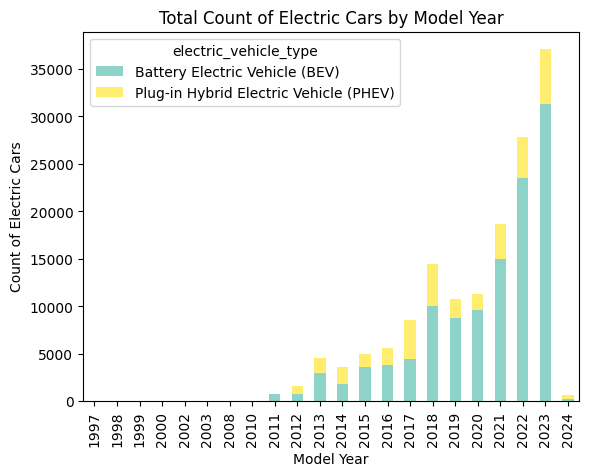

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the dataset is already loaded into the 'electric_cars' DataFrame

# Group the data by model year and electric vehicle type, and calculate the total count of electric cars
grouped_data = electric_cars.groupby(['model_year', 'electric_vehicle_type'])['n_cars'].sum().reset_index()

# Pivot the data to have electric vehicle types as columns
pivot_data = grouped_data.pivot(index='model_year', columns='electric_vehicle_type', values='n_cars')

# Plot the bar plot
pivot_data.plot(kind='bar', stacked=True, colormap='Set3')

# Set the labels and title
plt.xlabel('Model Year')
plt.ylabel('Count of Electric Cars')
plt.title('Total Count of Electric Cars by Model Year')

# Show the plot
plt.show()

Viola! This was fun!